# Extracting Building Values from an API

In [1]:
import pandas as pd
import json
import requests 
import zipcodes
import http.client 
import matplotlib.pyplot as plt
from collections import defaultdict 

## [ATTOM API Docs](https://api.developer.attomdata.com/docs)

In [2]:
# Input the desired zipcode
while True: 
    zipinput = input("Enter a zip code value ")
    
    if zipcodes.is_real(zipinput):
        
        break
        
    else:
        print("Invalid zip code...re-enter zip code")


Enter a zip code value 78758


In [3]:
# Input the date of the desired valuations
while True:
    year = input("Enter the current year in 4 digits: ")
    if len(year)==4:
        year=int(year)
        break
    else:
        print("Invalid Year. Please Enter the Year as 4-digits.")
        
while True:
    month = input("Enter the current month in 2 digits: ")
    if len(month)==2:
        month=int(month)
        break
    else:
        print("Invalid Year. Please Enter a Zero before a 1-digit month.")
        
while True:
    day = input("Enter the current day in 2 digits: ")
    if len(day)==2:
        day=int(day)
        break
    else:
        print("Invalid Date. Please Enter a Zero before a 1-digit day.")


Enter the current year in 4 digits: 2020
Enter the current month in 2 digits: 02
Enter the current day in 2 digits: 21


In [4]:
# Pull data on property values from the previous year from the given date, from the ATTOM Data API
with open('../../misc/api_keys/attom_a.txt') as f:
    key = f.read().strip()

conn = http.client.HTTPSConnection("api.gateway.attomdata.com") 
headers = { 
    'accept': "application/json", 
    'apikey': key
    } 
conn.request("GET",f"/propertyapi/v1.0.0/assessment/detail?geoid=ZI{zipinput}&startcalendardate={year-1}-{month}-{day}&endcalendardate={year}-{month}-{day}&page=1&pagesize=10000", headers=headers)

res = conn.getresponse() 
data = res.read() 

dict1 = json.loads(data.decode("utf-8"))

In [5]:
dict1['property'][0].keys()  #all the keys for the first property in the list

dict_keys(['identifier', 'lot', 'area', 'address', 'location', 'summary', 'utilities', 'building', 'vintage', 'assessment'])

In [6]:
pd.DataFrame(dict1['property'][0]) # the values for the first property in the list

,identifier,lot,area,address,location,summary,utilities,building,vintage,assessment
obPropId,3570578948453,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fips,48453,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
apn,239656,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
apnOrig,239656,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
attomId,35705789,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
depth,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
frontage,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
lotnum,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
lotsize1,NaN,0.6146,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
lotsize2,NaN,26772,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
dict1['property'][0]['assessment']['assessed']

{'assdimprpersizeunit': 111.01,
 'assdimprvalue': 609093,
 'assdlandpersizeunit': 25.0,
 'assdlandvalue': 669350,
 'assdttlpersizeunit': 232.99,
 'assdttlvalue': 1278443}

In [8]:
dict1['property'][0]['assessment']['appraised']

{'apprimprvalue': 609093, 'apprlandvalue': 669350, 'apprttlvalue': 1278443}

In [9]:
dict1['property'][0]['assessment']['calculations']

{'calcimprind': 'MARKET VALUE',
 'calcimprpersizeunit': 111.01,
 'calcimprvalue': 609093,
 'calclandind': 'MARKET VALUE',
 'calclandpersizeunit': 47.75,
 'calclandvalue': 669350,
 'calcttlind': 'MARKET VALUE',
 'calcttlvalue': 1278443,
 'calcvaluepersizeunit': 232.99}

In [10]:
dict1['property'][0]['assessment']['market']

{'mktimprvalue': 609093, 'mktlandvalue': 669350, 'mktttlvalue': 1278443}

In [11]:
df_property = pd.DataFrame({
    'zip_input': [zipinput for num in range((len(dict1['property'])))],
    'zipcode': [dict1['property'][num]['address']['postal1'] for num in range((len(dict1['property'])))],
    'state': [dict1['property'][num]['address']['countrySubd'] for num in range((len(dict1['property'])))],
    'address': [dict1['property'][num]['address']['line1'] for num in range((len(dict1['property'])))],
    'property_type': [dict1['property'][num]['summary']['proptype'] for num in range((len(dict1['property'])))],
    'property_code': [dict1['property'][num]['summary']['propIndicator'] for num in range((len(dict1['property'])))],
    'city': [dict1['property'][num]['address']['locality'] for num in range((len(dict1['property'])))],
    'latitude': [dict1['property'][num]['location']['latitude'] for num in range((len(dict1['property'])))],
    'longitude': [dict1['property'][num]['location']['longitude'] for num in range((len(dict1['property'])))],
    'sqft': [dict1['property'][num]['lot']['lotsize1'] for num in range((len(dict1['property'])))],
    'appraised_improved_value': [dict1['property'][num]['assessment']['appraised']['apprimprvalue'] for num in range((len(dict1['property'])))],
    'appraised_land_value': [dict1['property'][num]['assessment']['appraised']['apprlandvalue'] for num in range((len(dict1['property'])))],
    'appraised_total_value': [dict1['property'][num]['assessment']['appraised']['apprttlvalue'] for num in range((len(dict1['property'])))],
    'assessed_improved_value': [dict1['property'][num]['assessment']['assessed']['assdimprvalue'] for num in range((len(dict1['property'])))],
    'assessed_land_value': [dict1['property'][num]['assessment']['assessed']['assdlandvalue'] for num in range((len(dict1['property'])))],
    'assessed_total_value': [dict1['property'][num]['assessment']['assessed']['assdttlvalue'] for num in range((len(dict1['property'])))],
    'calculated_improved_value': [dict1['property'][num]['assessment']['calculations']['calcimprvalue'] for num in range((len(dict1['property'])))],
    'calculated_land_value': [dict1['property'][num]['assessment']['calculations']['calclandvalue'] for num in range((len(dict1['property'])))],
    'calculated_total_value': [dict1['property'][num]['assessment']['calculations']['calcttlvalue'] for num in range((len(dict1['property'])))],
    'market_value': [dict1['property'][num]['assessment']['market']['mktttlvalue'] for num in range((len(dict1['property'])))],
})

print(df_property.shape)
print(f'There are {df_property.shape[0]} properties found in the {zipinput} zip code for the year preceding {month}/{day}/{year}.')
df_property.head()

(9264, 20)
There are 9264 properties found in the 78758 zipcode for the year preceding 2/21/2020.


,zip_input,zipcode,state,address,property_type,property_code,city,latitude,longitude,sqft,appraised_improved_value,appraised_land_value,appraised_total_value,assessed_improved_value,assessed_land_value,assessed_total_value,calculated_improved_value,calculated_land_value,calculated_total_value,market_value
0,78758,78753,TX,8130 N LAMAR BLVD,COMMON AREA,20,Austin,30.350847,-97.709514,0.6146,609093,669350,1278443,609093,669350,1278443,609093,669350,1278443,1278443
1,78758,78753,TX,8128 N LAMAR BLVD,COMMON AREA,20,Austin,30.350848,-97.709513,2.8753,3591733,2348438,5940171,3591733,2348438,5940171,3591733,2348438,5940171,5940171
2,78758,78758,TX,8105 RESEARCH BLVD TRLR 17B,MOBILE HOME,10,Austin,30.353350,-97.714063,0.0000,4384,0,4384,4384,0,4384,4384,0,4384,4384
3,78758,78758,TX,8105 RESEARCH BLVD TRLR 16B,MOBILE HOME,10,Austin,30.353350,-97.714063,0.0000,393,0,393,393,0,393,393,0,393,393
4,78758,78758,TX,8001 RESEARCH BLVD,COMMON AREA,20,Austin,30.352867,-97.713866,14.1869,5707691,6952309,12660000,5707691,6952309,12660000,5707691,6952309,12660000,12660000


In [12]:
# Data Dictionary for property types
# """Property Type - Codes
# 10 Single Family Residence / Townhouse/
# 11 Condominium (residential)/
# 20 Commercial
# 21 Duplex, Triplex, Quadplex/
# 22 Apartment/
# 23 Hotel, Motel/
# 24 Commercial (condominium)
# 25 Retail/
# 27 Office Building/
# 28 Warehouse/
# 29 Financial Institution/
# 30 Hospital (medical complex, clinic)
# 50 Industrial/
# 51 Industrial Light/
# 52 Industrial Heavy/
# 54 Utilities
# 70 Agricultural/
# 80 Vacant/
# 90 Exempt"""


In [13]:
value_cols = list(df_property.columns[df_property.columns.str.contains('value')])
value_cols

['appraised_improved_value',
 'appraised_land_value',
 'appraised_total_value',
 'assessed_improved_value',
 'assessed_land_value',
 'assessed_total_value',
 'calculated_improved_value',
 'calculated_land_value',
 'calculated_total_value',
 'market_value']

In [14]:
final = {}
final['zipcode'] = 78701
final['count_property'] = df_property['address'].count()

for col in value_cols:
    final[f'sum_{col}'] = 0
    for value in df_property[col]:
#         print(value)
        final[f'sum_{col}'] += value
    final[f'avg_{col}'] = round(final[f'sum_{col}']/len(df_property[col]),2)
pd.DataFrame([final])

,zipcode,count_property,sum_appraised_improved_value,avg_appraised_improved_value,sum_appraised_land_value,avg_appraised_land_value,sum_appraised_total_value,avg_appraised_total_value,sum_assessed_improved_value,avg_assessed_improved_value,...,sum_assessed_total_value,avg_assessed_total_value,sum_calculated_improved_value,avg_calculated_improved_value,sum_calculated_land_value,avg_calculated_land_value,sum_calculated_total_value,avg_calculated_total_value,sum_market_value,avg_market_value
0,78701,9264,6036422347,651599.99,2544186582,274631.54,8582073631,926389.64,5354650944,578006.36,...,8409831673,907797.03,6037648400,651732.34,2549541774,275209.6,8587190174,926941.94,8587190174,926941.94


In [15]:
def get_custom_describe(value_col, df_group=df_property.groupby(['property_type'])):
    return pd.DataFrame({
                        'count': df_group[value_col].count(),
                        'mean': df_group[value_col].mean().map('${:,.2f}'.format),
                        'std': df_group[value_col].std().map('${:,.2f}'.format),
                        'median_val': df_group[value_col].median().map('${:,.2f}'.format),
                        'min_val': df_group[value_col].min().map('${:,.2f}'.format),
#                         '25_percentile': df_group[value_col].quantile(.25).map('${:,.2f}'.format),
#                         '75_percentile': df_group[value_col].quantile(.75).map('${:,.2f}'.format),
                        'max_val': df_group[value_col].max().map('${:,.2f}'.format),
                        'max_total': df_group[value_col].sum().map('${:,.2f}'.format)

    })

In [16]:
df = get_custom_describe(df_group=df_property, value_col=['calculated_land_value', 'calculated_improved_value', 
                                                      'calculated_total_value'])
df = df.T.copy()
df.drop(['count', 'std'], inplace=True)
df.rename(columns={
    'calculated_land_value': 'Land Value', 
    'calculated_improved_value': 'Improved Value On the Land', 
    'calculated_total_value': 'Total Property Value'
}, inplace=True)
df.rename({
    'mean': 'Mean Property Value',
    'min_val': 'Minimum Property Value',
    'median_val': 'Median Property Value',
    'max_val': 'Maximum Property Value',
    'max_total': 'TOTAL PROPERTIES VALUE'  
}, inplace=True)
df

,Land Value,Improved Value On the Land,Total Property Value
Mean Property Value,"$275,209.60","$651,732.34","$926,941.94"
Median Property Value,"$125,000.00","$170,138.50","$288,392.50"
Minimum Property Value,$0.00,$0.00,$11.00
Maximum Property Value,"$150,478,020.00","$233,220,744.00","$305,000,000.00"
TOTAL PROPERTIES VALUE,"$2,549,541,774.00","$6,037,648,400.00","$8,587,190,174.00"


In [17]:
get_custom_describe(value_col='calculated_improved_value')

,count,mean,std,median_val,min_val,max_val,max_total
property_type,,,,,,,
AGRICULTURAL (NEC),6,$0.00,$0.00,$0.00,$0.00,$0.00,$0.00
COMMON AREA,751,"$4,027,696.68","$15,168,611.01","$714,180.00",$0.00,"$233,220,744.00","$3,024,800,209.00"
COMMUNICATION FACILITY,1,"$2,500.00",$nan,"$2,500.00","$2,500.00","$2,500.00","$2,500.00"
CONDOMINIUM,1581,"$364,202.01","$3,570,217.14","$153,569.00",$0.00,"$116,861,736.00","$575,803,381.00"
DUPLEX,1084,"$186,832.72","$28,261.69","$186,847.00","$1,000.00","$390,852.00","$202,526,666.00"
FARMS,22,"$2,741.14","$10,173.03",$0.00,$0.00,"$46,281.00","$60,305.00"
MOBILE HOME,65,"$4,154.63","$4,893.36","$2,970.00",$393.00,"$24,077.00","$270,051.00"
MULTI FAMILY DWELLING,82,"$15,455,848.62","$21,542,998.33","$4,736,455.50",$0.00,"$115,011,933.00","$1,267,379,587.00"
QUADRUPLEX,93,"$313,241.96","$66,850.82","$325,300.00",$528.00,"$455,077.00","$29,131,502.00"


In [18]:
get_custom_describe(value_col='calculated_land_value')

,count,mean,std,median_val,min_val,max_val,max_total
property_type,,,,,,,
AGRICULTURAL (NEC),6,"$751,139.50","$939,030.77","$405,761.00","$89,754.00","$2,585,424.00","$4,506,837.00"
COMMON AREA,751,"$1,497,625.60","$4,111,666.59","$601,125.00",$0.00,"$71,779,256.00","$1,124,716,829.00"
COMMUNICATION FACILITY,1,"$61,143.00",$nan,"$61,143.00","$61,143.00","$61,143.00","$61,143.00"
CONDOMINIUM,1581,"$25,011.63","$236,795.72",$382.00,$39.00,"$7,778,264.00","$39,543,389.00"
DUPLEX,1084,"$125,181.39","$34,693.00","$125,000.00","$41,563.00","$1,216,625.00","$135,696,626.00"
FARMS,22,"$2,047,794.95","$4,654,726.79","$528,418.50",$555.00,"$21,928,110.00","$45,051,489.00"
MOBILE HOME,65,"$16,481.15","$123,197.65",$0.00,$0.00,"$991,275.00","$1,071,275.00"
MULTI FAMILY DWELLING,82,"$3,237,307.96","$3,977,003.69","$1,559,211.00","$70,803.00","$14,378,067.00","$265,459,253.00"
QUADRUPLEX,93,"$123,407.26","$13,362.73","$125,000.00","$1,250.00","$137,500.00","$11,476,875.00"


In [19]:
get_custom_describe(value_col='calculated_total_value') # total value includes value of the land 

,count,mean,std,median_val,min_val,max_val,max_total
property_type,,,,,,,
AGRICULTURAL (NEC),6,"$751,139.50","$939,030.77","$405,761.00","$89,754.00","$2,585,424.00","$4,506,837.00"
COMMON AREA,751,"$5,525,322.29","$18,108,904.52","$1,462,937.00",$38.00,"$305,000,000.00","$4,149,517,038.00"
COMMUNICATION FACILITY,1,"$63,643.00",$nan,"$63,643.00","$63,643.00","$63,643.00","$63,643.00"
CONDOMINIUM,1581,"$389,213.64","$3,801,196.41","$170,833.00",$169.00,"$124,640,000.00","$615,346,770.00"
DUPLEX,1084,"$312,014.11","$42,405.96","$311,473.50","$120,755.00","$1,217,625.00","$338,223,292.00"
FARMS,22,"$2,050,536.09","$4,653,784.22","$528,418.50",$555.00,"$21,928,110.00","$45,111,794.00"
MOBILE HOME,65,"$20,635.78","$125,671.97","$3,146.00",$393.00,"$1,014,648.00","$1,341,326.00"
MULTI FAMILY DWELLING,82,"$18,693,156.59","$25,049,117.41","$7,017,614.50","$70,803.00","$129,390,000.00","$1,532,838,840.00"
QUADRUPLEX,93,"$436,649.22","$74,562.10","$450,300.00","$1,778.00","$580,077.00","$40,608,377.00"


In [20]:
for row in df_property.T:
    if df_property['calculated_total_value'][row] != df_property['market_value'][row]:
        print(row)
#     else:
#         print('It is the same value.')

/Users/meggan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


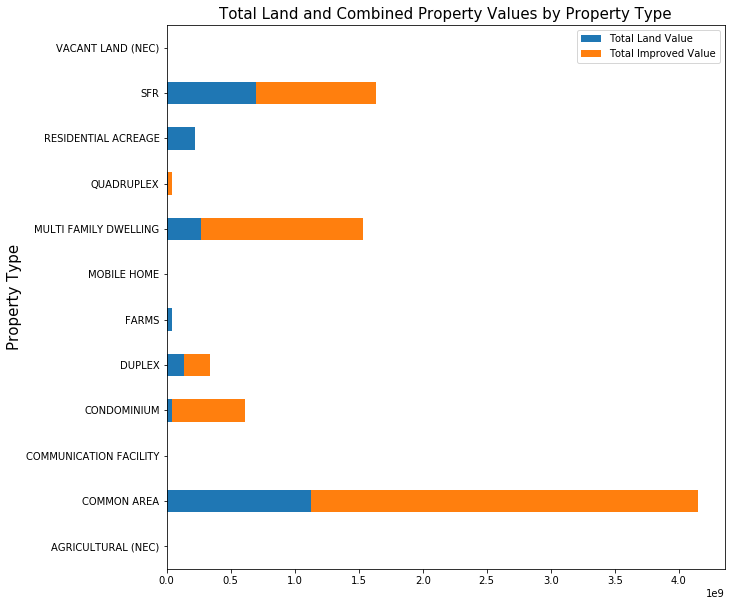

In [21]:
ax = df_property.groupby(['property_type'])['calculated_land_value', 
                                            'calculated_improved_value'].sum().plot.barh(figsize=(10,10), 
                                                                                         stacked=True)
ax.set_ylabel('Property Type', fontsize=15)
ax.set_title('Total Land and Combined Property Values by Property Type', fontsize=15)
ax.legend(('Total Land Value', 'Total Improved Value'))
;
plt.savefig(f'./images/stacked_property_val_chart_{zipinput}_{year}_{month}_{day}.png')

In [22]:
# Pull Sales time series data from the ATTOM API
conn2 = http.client.HTTPSConnection("api.gateway.attomdata.com") 
conn2.request("GET",f"/propertyapi/v1.0.0/salestrend/snapshot?geoid=ZI{zipinput}&interval=yearly&startyear=1979&endyear={year}", headers=headers)
res2 = conn2.getresponse() 
data2 = res2.read() 

dict2 = json.loads(data2.decode("utf-8"))

In [23]:
price_series = defaultdict(list)          #creates dictionary that's empty made of lists


#Build list of properties & key data
for price in dict2['salestrends']:
    price_series['location'].append(price['location']['geoID'])
    price_series['year'].append(price['daterange']['start'])
    price_series['SF_count'].append(price['SalesTrend']['homesalecount'])
    price_series['AvgSalePrice'].append(price['SalesTrend']['avgsaleprice'])
    price_series['MedianSalePrice'].append(price['SalesTrend']['medsaleprice'])
df = pd.DataFrame(price_series)

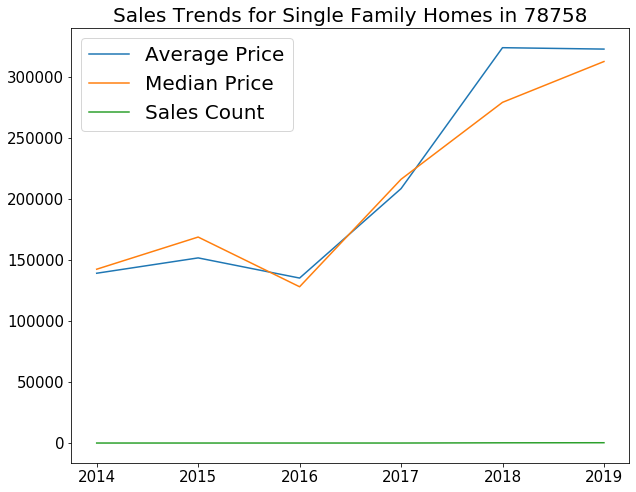

In [24]:

plt.figure(figsize=(10,8))
plt.title('Sales Trends for Single Family Homes in '+zipinput, fontsize=20)

for y_col in ['AvgSalePrice', 'MedianSalePrice', 'SF_count']:  
    plt.plot(df['year'], df[y_col])
    
plt.legend(labels=('Average Price', 'Median Price', 'Sales Count'), fontsize=20);
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig(f'./images/sales_trends_graph_{zipinput}_{year}_{month}_{day}.png')
plt.show();
